In [ ]:
import pandas as pd                                              # pandas is used for data manipulation and analysis
import networkx as nx                                            # networkx is used for creating, manipulating, and studying the structure, dynamics, and functions of complex networks
import matplotlib.pyplot as plt                                  # matplotlib is used for plotting and visualization of data
from sklearn.feature_extraction.text import CountVectorizer      # CountVectorizer is used to convert a collection of text documents to a matrix of token counts
from sklearn.model_selection import train_test_split, GridSearchCV  # train_test_split is used to split the dataset into training and testing sets
from sklearn.ensemble import RandomForestClassifier              # RandomForestClassifier is an ensemble method used for classification tasks
from sklearn.pipeline import Pipeline                            # Pipeline is used to streamline a sequence of transformations and the final estimator
from sklearn.preprocessing import LabelEncoder, StandardScaler   # LabelEncoder is used to encode target labels with value between 0 and n_classes-1
from sklearn.metrics import classification_report                # classification_report is used to compute and display a detailed classification report
from imblearn.over_sampling import SMOTE                         # SMOTE is used to perform Synthetic Minority Over-sampling Technique to handle imbalanced datasets
from imblearn.pipeline import Pipeline as ImbPipeline            # ImbPipeline from imblearn is used to create a pipeline that can handle imbalanced data
from imblearn.metrics import classification_report_imbalanced    # classification_report_imbalanced is used to compute and display a detailed classification report for imbalanced data
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay# confusion_matrix is used to compute the confusion matrix to evaluate the accuracy of a classification

In [12]:

# Loading Data: Reads the CSV file into a DataFrame using pandas.
file_path = "C:\\Users\\ARUN ROSHAN\\OneDrive\\Documents\\ctsprojectfinalcodee\\new_disease_symptoms_dataset1.csv"
data = pd.read_csv(file_path)

# Creating the Graph: Initializes an empty graph G_subset using NetworkX.
G_subset = nx.Graph()

# Iterating Through Rows:

# For each row, a patient node is added to the graph with an identifier like "Patient1".
for _, row in data.iterrows():
    patient_id = f"Patient{row['PatientID']}"
    G_subset.add_node(patient_id, type='Patient')

# A disease node is added, and an edge is created between the patient and the disease indicating that the patient suffers from the disease.
    disease = row['Disease']
    G_subset.add_node(disease, type='Disease')
    G_subset.add_edge(patient_id, disease, type='SuffersFrom')

# Symptoms are split from a comma-separated string and processed:
    symptoms = row['Symptoms'].split(',')

# Edges are created between the patient and each symptom (indicating the patient has the symptom).
# Edges are also created between the disease and each symptom (indicating the disease is associated with the symptom).
    for symptom in symptoms:
        symptom = symptom.strip()
        G_subset.add_node(symptom, type='Symptom')

        G_subset.add_edge(patient_id, symptom, type='HasSymptom')
        G_subset.add_edge(disease, symptom, type='AssociatedWith')

In [3]:
# Visualizes the semantic network with nodes colored by type: red for Patients, blue for Diseases, and green for Symptoms.
def visualize_semantic_network(G):
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    for node in G.nodes:
        if G.nodes[node]['type'] == 'Patient':
            pos[node] = [0, 0]

    plt.figure(figsize=(12, 12))
    node_colors = ['red' if G.nodes[node]['type'] == 'Patient' else 'blue' if G.nodes[node]['type'] == 'Disease' else 'green' for node in G]
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color=node_colors, font_size=10, font_color='white')
    plt.title('Patient-Centric Semantic Network')
    plt.show()

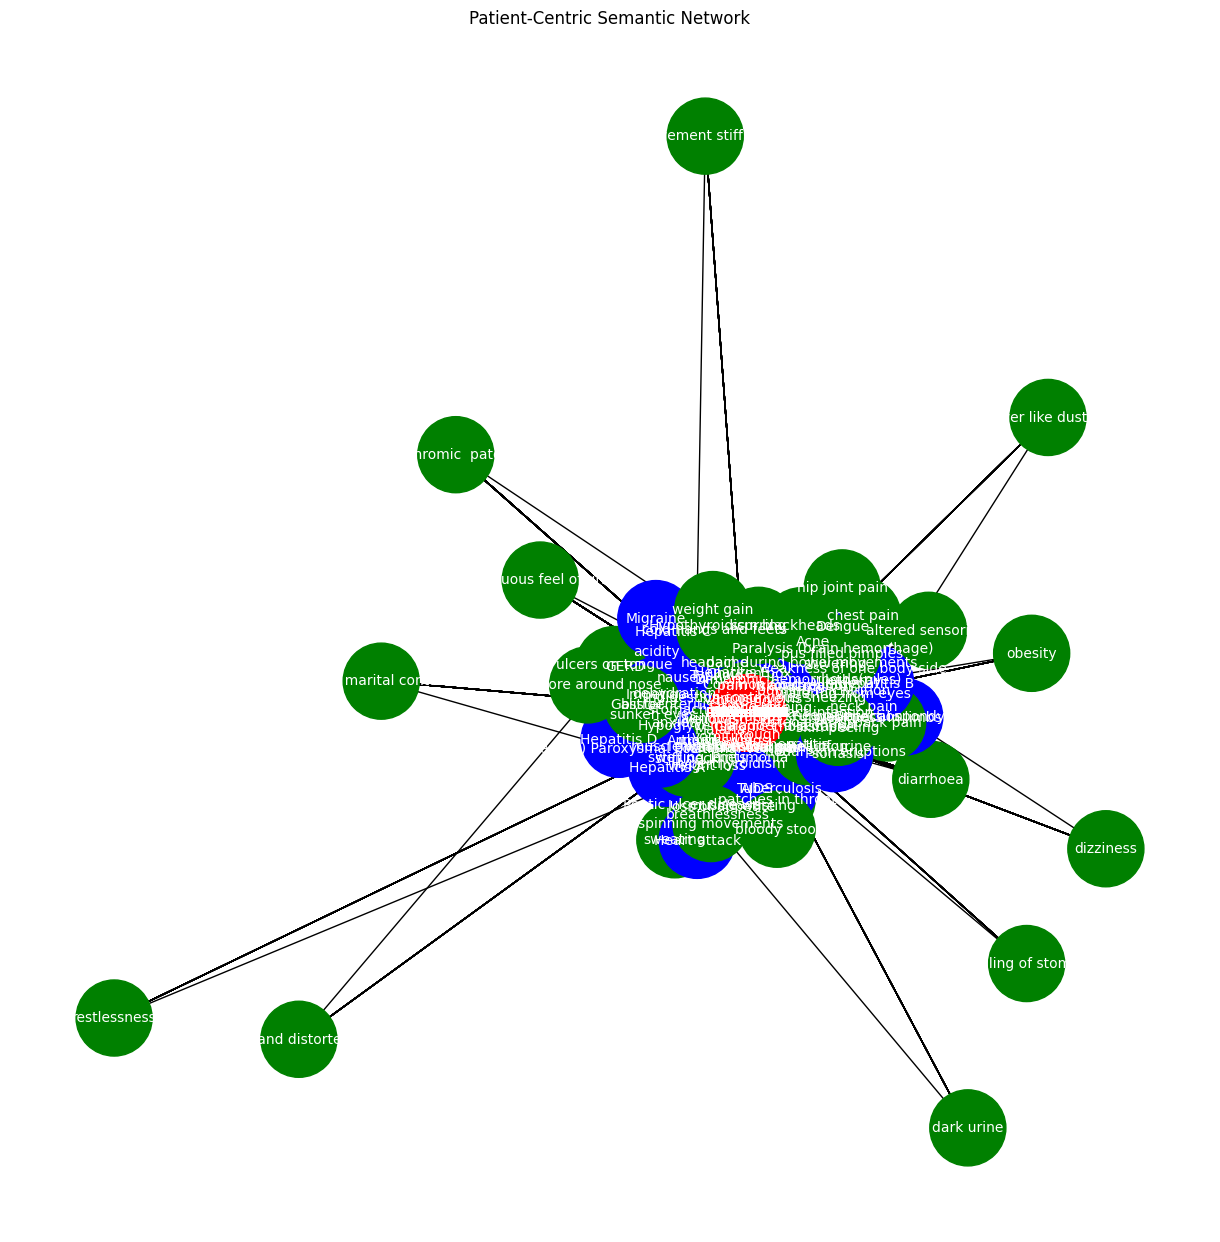

In [11]:
visualize_semantic_network(G_subset)

In [4]:
# Initialize empty lists for features (X) and labels (y)
X = []
y = []

# Function to extract features from the graph for each symptom
def extract_features(symptoms, graph):
    # Initialize an empty list to store features for each symptom
    features = []
    for symptom in symptoms:
        if symptom in graph:
            # Find neighboring nodes of the symptom that are of type 'Disease'
            disease_neighbors = [n for n in graph.neighbors(symptom) if graph.nodes[n]['type'] == 'Disease']
            # Append the count of disease neighbors to the features list
            features.append(len(disease_neighbors))
        else:
            # If symptom is not in the graph, append 0 to features list
            features.append(0)
    return features

# Iterate through each row in the dataset
for _, row in data.iterrows():
    # Split and clean the symptoms from the row
    symptoms = [s.strip() for s in row['Symptoms'].split(',')]
    # Extract features for the current symptoms using the defined function
    features = extract_features(symptoms, G_subset)
    # Append the extracted features to X
    X.append(features)
    # Append the corresponding disease to y
    y.append(row['Disease'])
    
# Encode the disease labels into numerical format for machine learning purposes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [22]:
# Convert the list of features (X) into a DataFrame and fill any NaN values with 0
df_X = pd.DataFrame(X).fillna(0)

# Initialize and fit a CountVectorizer to the 'Symptoms' column to convert symptoms into a bag-of-words representation
vectorizer = CountVectorizer()
X_symptoms = vectorizer.fit_transform(data['Symptoms'])

# Combine network-derived features with the raw symptom features
# - Convert the sparse matrix from CountVectorizer to a DataFrame with appropriate column names
# - Concatenate the DataFrame of network-derived features with the DataFrame of raw symptom features
X_combined = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(X_symptoms.toarray(), columns=vectorizer.get_feature_names_out())], axis=1)

# Ensure all column names are treated as strings for consistency in subsequent operations
X_combined.columns = X_combined.columns.astype(str)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)


In [23]:
# Define a machine learning pipeline with two steps:
# 1. StandardScaler: Scales features to have zero mean and unit variance.
# 2. RandomForestClassifier: Classifier using a random forest for prediction.
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step to standardize feature values
    ('clf', RandomForestClassifier(random_state=42))  # Random forest classifier with a fixed random seed for reproducibility
])

# Define the hyperparameters to tune for the RandomForestClassifier
# - 'clf__n_estimators': Number of trees in the forest
# - 'clf__max_depth': Maximum depth of the trees
param_grid = {
    'clf__n_estimators': [50, 100, 200],  # List of possible values for the number of trees
    'clf__max_depth': [None, 10, 20, 30]  # List of possible values for the maximum depth of trees
}

# Initialize GridSearchCV to perform an exhaustive search over specified hyperparameters
# - cv=5: 5-fold cross-validation to evaluate model performance
# - scoring='accuracy': Use accuracy as the metric to evaluate model performance
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV to the training data to find the best hyperparameters
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__max_depth': [None, 10, 20, 30],
                         'clf__n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [9]:
# Finding accuracy for the best model
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(f'Model Accuracy: {accuracy:.2f}')

Model Accuracy: 0.95


In [13]:

# Predict on the test set
y_pred = best_model.predict(X_test)

# Check unique labels in y_test and label_encoder.classes_
print("Labels in y_test:", set(y_test))
print("Labels in label_encoder.classes_:", set(label_encoder.classes_))





Labels in y_test: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38}
Labels in label_encoder.classes_: {'Dengue', 'Malaria', 'Varicose veins', 'Jaundice', 'Psoriasis', 'Drug Reaction', 'GERD', 'AIDS', 'Hepatitis B', 'Tuberculosis', '(vertigo) Paroxysmal Positional Vertigo', 'Alcoholic hepatitis', 'Migraine', 'Paralysis (brain hemorrhage)', 'Gastroenteritis', 'Hepatitis E', 'Common Cold', 'Cervical spondylosis', 'Fungal infection', 'Dimorphic hemorrhoids(piles)', 'Chicken pox', 'Hypoglycemia', 'Impetigo', 'Heart attack', 'Osteoarthritis', 'Urinary tract infection', 'Hyperthyroidism', 'Hypothyroidism', 'Hepatitis A', 'Arthritis', 'Allergy', 'Typhoid', 'Chronic cholestasis', 'Pneumonia', 'Peptic ulcer disease', 'Hepatitis D', 'Hepatitis C', 'Acne', 'Bronchial Asthma'}


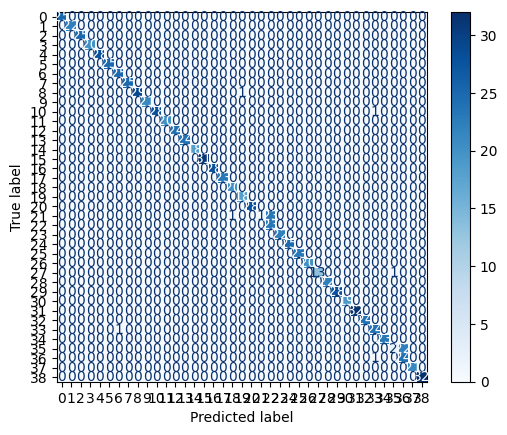

Accuracy: 0.95
Macro Average - Precision: 0.96, Recall: 0.95, F1-Score: 0.93
Weighted Average - Precision: 0.96, Recall: 0.95, F1-Score: 0.93


In [14]:
# Predict on the test set
y_pred = best_model.predict(X_test)

unique_labels = sorted(set(y_test) | set(y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Get the classification report as a dictionary
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Extract metrics
accuracy = report_dict['accuracy']
macro_avg = report_dict['macro avg']
weighted_avg = report_dict['weighted avg']

# Print extracted metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Macro Average - Precision: {macro_avg['precision']:.2f}, Recall: {macro_avg['recall']:.2f}, F1-Score: {macro_avg['f1-score']:.2f}")
print(f"Weighted Average - Precision: {weighted_avg['precision']:.2f}, Recall: {weighted_avg['recall']:.2f}, F1-Score: {weighted_avg['f1-score']:.2f}")


In [15]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Define SMOTE
smote = SMOTE(random_state=42)

# Define the pipeline with SMOTE and the classifier
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', smote),
    ('clf', RandomForestClassifier(random_state=42))
])

# Define hyperparameters for GridSearchCV
param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20, 30]
}

# Tune the model
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
# Evaluate the model
accuracy = best_model.score(X_test, y_test)
print(f'Model Accuracy (with SMOTE): {accuracy:.2f}')

Model Accuracy (with SMOTE): 0.95


In [18]:
import pickle
import os

In [19]:
# Save the model, vectorizer, and label encoder to a file using pickle
model_components = {
    'model': best_model,
    'vectorizer': vectorizer,
    'label_encoder': label_encoder
}

model_file_path = "model_components1.pkl"
with open(model_file_path, 'wb') as model_file:
    pickle.dump(model_components, model_file)

In [20]:
def predict_disease(symptoms):
    # Extract features from the input symptoms
    features = extract_features(symptoms.split(','), G_subset)
    
    # Create DataFrame for features and ensure it has the same columns as X_combined
    features_df = pd.DataFrame([features]).fillna(0)
    features_vectorized = vectorizer.transform([', '.join(symptoms.split(','))]).toarray()
    features_vectorized_df = pd.DataFrame(features_vectorized, columns=vectorizer.get_feature_names_out())
    
    # Combine network-derived features with vectorized symptoms
    combined_features = pd.concat([features_df.reset_index(drop=True), features_vectorized_df], axis=1).reindex(columns=X_combined.columns, fill_value=0)
    
    # Predict the disease
    disease_encoded = best_model.predict(combined_features)[0]
    disease = label_encoder.inverse_transform([disease_encoded])[0]
    
    # Extract and print disease-related information
    disease_info = data[data['Disease'] == disease].iloc[0]
    description = disease_info['Description']
    precautions = disease_info['Precautions']
    medications = disease_info['Medications']
    diet = disease_info['Diet']
    workout = disease_info['Workout']
    
    return disease, description, precautions, medications,diet,workout

In [21]:
new_symptoms = 'skin rash, high fever, blister'  # Replace with actual symptoms
predicted_disease, description, precautions, medications, diet, workout = predict_disease(new_symptoms)
print(f'Predicted Disease: {predicted_disease}')
print(f'Description: {description}')
print(f'Precautions: {precautions}')
print(f'Medications: {medications}')
print(f'Diet: {diet}')
print(f'Workout: {workout}')

Predicted Disease: Impetigo
Description: Impetigo is a highly contagious skin infection causing red sores that can break open.
Precautions: soak affected area in warm water, use antibiotics, remove scabs with wet compressed cloth, consult doctor
Medications: Topical antibiotics', 'Oral antibiotics', 'Antiseptics', 'Ointments', 'Warm compresses'
Diet: Impetigo Diet', 'Antibiotic treatment', 'Fruits and vegetables', 'Hydration', 'Protein-rich foods'
Workout: Maintain good hygiene, Stay hydrated, Consume nutrient-rich foods, Limit sugary foods and beverages, Include foods rich in vitamin C, Consult a healthcare professional, Follow medical recommendations, Avoid scratching, Take prescribed antibiotics, Practice wound care
